# Monitor coupling in M1M3 VMS system and TMA drives together

* This notebook is originally written by Dominique Boutigny associated to [SITCOM-784](https://rubinobs.atlassian.net/browse/SITCOM-784)
* It contains the analysis associated to the Technical Note: SITCOMTN-131
* The original notebook was editted by HyeYun Park for [SITCOM-1390](https://rubinobs.atlassian.net/browse/SITCOM-1390)
* to provide additional plots to the SITCOMTN-081, associated with SITCOM-918

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext lab_black

In [2]:
import os.path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import h5py
import numpy as np

from astropy.time import Time
from astropy.time import TimeDelta
from astropy import units as u
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib import ticker
from scipy.signal import stft
from scipy.signal import find_peaks_cwt
from scipy import signal
from scipy.fft import fft, rfft, fftfreq, rfftfreq


from lsst_efd_client import EfdClient
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState, TMAEvent
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient, getSubTopics
from lsst.ts.xml.enums import MTM1M3, MTMount

In [3]:
# Utility functions
key_m1m3_dict = {
    "1 X": "m1m3_x_1",
    "1 Y": "m1m3_y_1",
    "1 Z": "m1m3_z_1",
    "2 X": "m1m3_x_2",
    "2 Y": "m1m3_z_2",  # note these two have been
    "2 Z": "m1m3_y_2",  # switched pending SUMMIT-7911
    "3 X": "m1m3_x_3",
    "3 Y": "m1m3_y_3",
    "3 Z": "m1m3_z_3",
}
key_m2_dict = {
    "1 X": "m2_x_1",
    "1 Y": "m2_y_1",
    "1 Z": "m2_z_1",
    "2 X": "m2_x_2",
    "2 Y": "m2_z_2",
    "2 Z": "m2_y_2",
    "3 X": "m2_x_3",
    "3 Y": "m2_z_3",
    "3 Z": "m2_y_3",
    "4 X": "m2_x_4",
    "4 Y": "m2_y_4",
    "4 Z": "m2_z_4",
    "5 X": "m2_x_5",
    "5 Y": "m2_z_5",
    "5 Z": "m2_y_5",
    "6 X": "m2_x_6",
    "6 Y": "m2_z_6",
    "6 Z": "m2_y_6",
}


def vms_data_to_pandas(filename, vms_type, begin_time=None, end_time=None):
    """
    Converts VMS data in the given HDF5 file to a Pandas DataFrame.

    Args:
    filename: Path to the HDF5 file containing the VMS data.
    vms_type: The type of VMS data in the file. Must be "m1m3", "m2", or
      "rotator".
    begin_time: The start time of the data to include in the DataFrame. If None,
      all data will be included.
    end_time: The end time of the data to include in the DataFrame. If None, all
      data will be included.

    Returns:
    A Pandas DataFrame containing the VMS data.
    """
    if vms_type == "m1m3":
        key_dict = key_m1m3_dict
    elif vms_type == "m2":
        key_dict = key_m2_dict
    elif vms_type == "rotator":
        raise NotImplementedError
    else:
        raise ValueError("vms_type must be m1m3,m2, or rotator")

    f = h5py.File(filename, "r")
    times = f["timestamp"][::1]
    dkeys = "XYZ"

    data_dict = {}
    if (begin_time is not None) & (end_time is not None):
        sel = (times > begin_time) & (times < end_time)
    else:
        sel = np.ones(times.size).astype(bool)
    data_dict["times"] = times[sel]
    for key in key_dict.keys():
        # multiply values stored in hdf5 files by 2 in order to convert the acceleration values to mg
        data_dict[key_dict[key]] = f[key][::1][sel] * 2.0
    data_frame = pd.DataFrame(data_dict)
    for j in np.arange(int(len(key_dict) / 3)) + 1:
        data_frame[f"total_{j}"] = np.linalg.norm(
            data_frame[[f"{vms_type}_{i}_{j}" for i in ["x", "y", "z"]]].values, axis=1
        )

    return data_frame


def get_freq_psd(vals, timestep):
    """
    Calculates the frequency power spectrum of a signal.

    Args:
        vals (np.array): The signal values.
        timestep (float): The time step between samples.

    Returns:
        tuple: The frequencies and power spectral density.
    """

    # Remove the mean from the signal.

    meanval = np.mean(vals)
    signal = vals - meanval

    # Calculate the length of the signal.

    N = len(signal)

    # Calculate the power spectral density.

    psd = np.abs(np.fft.rfft(np.array(signal) * 1)) ** 2

    # Calculate the frequencies.

    frequencies = np.fft.rfftfreq(N, timestep)
    return (frequencies, psd)


def get_psd_and_dsd_for_vms(vals, timestep, min_freq=1, g=False):
    """
    Calculate the PSD and DSD from VMS data, and total displacement from DSD.

    Parameters:
    - vals (array-like): VMs in m/s^2 or milli-g if 'g' is True.
    - timestep (float): Time step between measurements in seconds.
    - min_freq (float, optional): Minimum frequency for calculations.
                                  Default is 1 Hz.
    - g (bool, optional): True if 'vals' are in milli-g units.
                          Default is False.

    Returns:
    - psds_df (DataFrame): DataFrame with frequencies ('freq'), acceleration
                           PSD ('accel_psd'), displacement PSD ('disp_psd'),
                           and cumulative displacement PSD ('int_disp').
    - total_displacement (float): Total displacement from vibration data.

    Note:
    PSD adjusted to m/s^2/Hz. 'vals' converted to m/s^2 if 'g' is True.
    """
    if g:
        vals = 1e-3 * 9.8 * vals

    # freq, accel_psd = signal.periodogram(vals, 1/timestep)
    # print("using scipy")
    freq, accel_psd = get_freq_psd(vals, timestep)

    sel = freq > min_freq
    freq = freq[sel]
    accel_psd = accel_psd[sel]

    accel_psd = accel_psd * np.mean(np.diff(freq))

    disp_psd_sq = accel_psd / ((2 * np.pi * freq) ** 4)

    int_displace_psd = np.sqrt(np.cumsum(disp_psd_sq))
    total_displacement = np.sqrt(np.sum(disp_psd_sq))

    psds_df = pd.DataFrame(
        {
            "freq": freq,
            "accel_psd": accel_psd,
            "disp_psd": np.sqrt(disp_psd_sq),
            "int_disp": int_displace_psd,
        }
    )

    return psds_df, total_displacement

In [4]:
# Create a directory to save plots
plot_dir = "./plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [54]:
# Acquisition date of VMS data (need to download vms data. Dominique has one for 2023.11.29)
vms_date ="2024-01-04" #"2023-11-29"

vms_top_dir = "/sdf/scratch/users/b/boutigny/vmsdata"
year, month = vms_date.split("-")[0:2]

# Directory containing VMS data
vms_dir = os.path.join("/scratch/users/b/boutigny/vmsdata", year, month)

# Check if a parquet file exists
# If yes, we read the pandas dataframe directly from it
# If not, we read the hdf file and re-create the pandas dataframe
vms_m1m3_parquet_filename = os.path.join(vms_dir, "M1M3-" + vms_date + "T00:00.parquet")
if os.path.isfile(vms_m1m3_parquet_filename):
    print(f"Reading VMS data from parquet file:{vms_m1m3_parquet_filename}")
    vms_m1m3_data = pd.read_parquet(vms_m1m3_parquet_filename)
else:
    vms_m1m3_hdf_filename = os.path.join(vms_dir, "M1M3-" + vms_date + "T00:00.hdf")
    print(f"Reading VMS data from hdf5 file:{vms_m1m3_hdf_filename}")
    vms_m1m3_data = vms_data_to_pandas(vms_m1m3_hdf_filename, vms_type="m1m3")
    # Remove entries with null timestamps
    vms_m1m3_data = vms_m1m3_data[vms_m1m3_data["times"] > 0]
    # Reformat timestamps
    vms_m1m3_data["times"] = Time(vms_m1m3_data["times"], format="unix").datetime

Reading VMS data from hdf5 file:/scratch/users/b/boutigny/vmsdata/2024/01/M1M3-2024-01-04T00:00.hdf


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/scratch/users/b/boutigny/vmsdata/2024/01/M1M3-2024-01-04T00:00.hdf', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

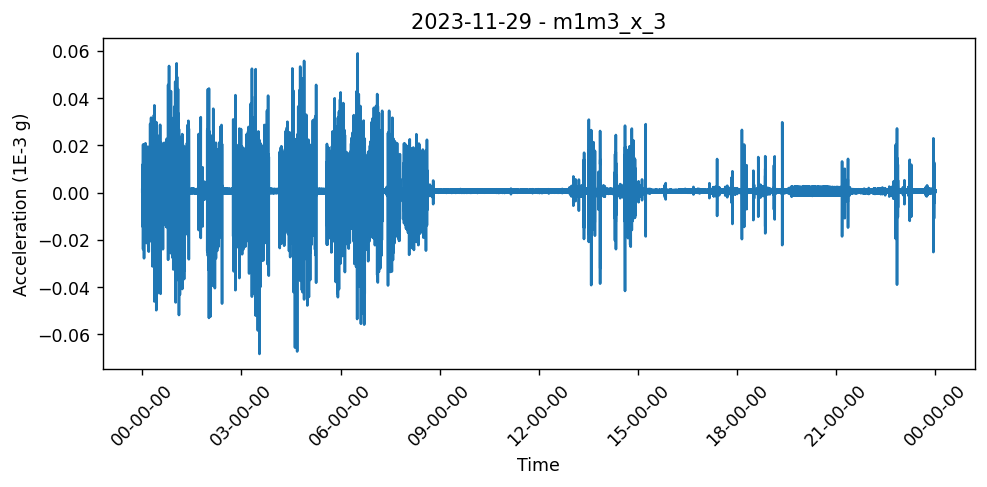

In [6]:
%matplotlib inline
# First look at the raw VMS data - We plot only 1 sensor and 1 axis because the full dataset is very large and requires too much memory
# to be displayed
fig, ax = plt.subplots(1, 1, dpi=125, figsize=(8, 4))
key = "m1m3_x_3"
ax.plot(vms_m1m3_data["times"], vms_m1m3_data[key])
ax.set(ylabel="Acceleration (1E-3 g)", xlabel="Time", title=f"{vms_date} - {key}")
ax.xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
plt.setp(ax.get_xticklabels(), rotation=45)
fig.tight_layout()
fig.savefig(f"{plot_dir}/VMS-accel-{vms_date}.png")

In [56]:
# Retrieve TMA events corresponding to the VMS acquisition date
# As VMS and TMA do not cover the same time window, we need to get the TMA events corresponding to both
# dayObs and the day before dayObs
vms_date = "2024-01-04"  # "2023-11-29"

dayObs = int(vms_date.replace("-", "", 2))
vms_time = Time(vms_date + "T00:00:00")
delta_t = TimeDelta(1, format="jd")
day_before = int(str(vms_time - delta_t)[0:10].replace("-", "", 2))
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(day_before)
events = events + eventMaker.getEvents(dayObs)

# Get lists of slew events
slews = [e for e in events if e.type == TMAState.SLEWING]
print(f"Found {len(slews)} slews")

Found 1465 slews


In [58]:
# Filter the list of slews in order to keep the ones that are fully contained within the day corresponding to the VMS file.
date_min = Time(f"{vms_date} 00:00:00.00").unix
date_end = Time(f"{vms_date} 23:59:59.00").unix
sel_slews = [
    slews[i]
    for i in range(len(slews))
    if (slews[i].begin.unix > date_min and slews[i].end.unix < date_end)
]
print(f"Selected {len(sel_slews)} slews out of {len(slews)} for {dayObs}")

Selected 963 slews out of 1465 for 20240104


In [59]:
# Check that all the selected slews fall within dayObs
print(sel_slews[0].begin.datetime64, sel_slews[-1].end.datetime64)

2024-01-04T00:00:09.398251295 2024-01-04T23:59:33.931989193


In [60]:
client = EfdClient("usdf_efd")

In [61]:
# Print slews amplitudes and speed in azimuth and elevation
# This is intended to help selecting large slews that will be studied in details
# The selected slew numbers will be stored in variables slew_azi and slew_ele
# by default they contain the slews with the largest amplitudes
max_delta_azi = -99
max_delta_ele = -99
for i_slew, slew in enumerate(sel_slews):
    df_ele = getEfdData(client, "lsst.sal.MTMount.elevation", event=slew)
    df_azi = getEfdData(client, "lsst.sal.MTMount.azimuth", event=slew)

    t1 = slew.begin.datetime64
    t2 = slew.end.datetime64
    if len(df_ele) > 0:
        slew_delta_ele = df_ele["actualPosition"].max() - df_ele["actualPosition"].min()
        if slew_delta_ele > 30:
            print(
                f"Slew number: {i_slew} - Delta ele: {slew_delta_ele:.1f} degrees - Speed: {abs(df_ele['actualVelocity']).max()}",
                df_ele["actualPosition"].min(),
                df_ele["actualPosition"].max(),
            )
        if slew_delta_ele > max_delta_ele:
            max_delta_ele = slew_delta_ele
            slew_ele = i_slew
    if len(df_azi) > 0:
        slew_delta_azi = df_azi["actualPosition"].max() - df_azi["actualPosition"].min()
        if slew_delta_azi > 30:
            print(
                f"Slew number: {i_slew} - Delta azi: {slew_delta_azi:.1f} degrees - Speed: {abs(df_azi['actualVelocity']).max()}",
                df_azi["actualPosition"].min(),
                df_azi["actualPosition"].max(),
            )
        if slew_delta_azi > max_delta_azi:
            max_delta_azi = slew_delta_azi
            slew_azi = i_slew
print(
    f"Maximum amplitude slew in azimuth: {slew_azi} / {max_delta_azi:.1f} degrees - in elevation: {slew_ele} / {max_delta_ele:.1f} degrees"
)

Slew number: 52 - Delta azi: 98.0 degrees - Speed: 7.0074962172346 -121.975005034978 -24.0004225154345
Slew number: 53 - Delta azi: 30.7 degrees - Speed: 7.00035577092531 -120.828153284852 -90.1153235595656
Slew number: 56 - Delta azi: 43.4 degrees - Speed: 6.99114838236372 -113.045780627685 -69.6630074042264
Slew number: 68 - Delta azi: 109.3 degrees - Speed: 4.00320228829173 -109.354445170093 -0.020263872221495
Slew number: 569 - Delta ele: 37.0 degrees - Speed: 3.50746463762443 45.0139656064568 82.0000003915834
Slew number: 575 - Delta azi: 100.0 degrees - Speed: 7.01022343269 -99.9794285643509 7.05763602886511e-08
Slew number: 576 - Delta azi: 200.0 degrees - Speed: 7.00697175273997 -100.000000264161 99.9696176086038
Slew number: 577 - Delta azi: 200.0 degrees - Speed: 7.00869420460788 -99.9613088443399 100.000000398689
Slew number: 578 - Delta azi: 200.0 degrees - Speed: 7.01112771994387 -100.000000192392 99.9682208966724
Slew number: 579 - Delta azi: 200.0 degrees - Speed: 7.0039

Slew number: 598 - Delta ele: 63.2 degrees - Speed: 0.000521182744238814 0.0 63.1538538225106


Slew number: 665 - Delta azi: 42.3 degrees - Speed: 6.99398490727508 -33.0080330746846 9.30089343142814
Slew number: 738 - Delta ele: 49.7 degrees - Speed: 0.00509806675700648 0.0 49.6725733551563


Slew number: 762 - Delta azi: 124.3 degrees - Speed: 6.98762729324951 -124.914644457836 -0.659510933813515


Slew number: 766 - Delta ele: 41.8 degrees - Speed: 0.50326411260021 19.999998336667 61.7626615088892
Slew number: 772 - Delta azi: 259.1 degrees - Speed: 7.01115973983462 -106.154618876121 152.936975599643
Slew number: 786 - Delta ele: 66.0 degrees - Speed: 5.0176061943242 19.999999794021 85.9794912320609
Slew number: 793 - Delta ele: 77.8 degrees - Speed: 0.503621268284125 -0.046272552547792 77.71916005119
Slew number: 795 - Delta ele: 57.6 degrees - Speed: 0.503200618258382 2.38774771883327 59.9986026356384
Slew number: 797 - Delta ele: 31.7 degrees - Speed: 0.502962514466986 58.2879312261577 89.9579738586971
Slew number: 807 - Delta ele: 65.5 degrees - Speed: 0.503110667938672 15.0018508604302 80.4973143690327
Slew number: 809 - Delta ele: 71.6 degrees - Speed: 0.503639787470869 18.3674987853686 89.9991011581424
Slew number: 815 - Delta azi: 153.0 degrees - Speed: 0.00038534339907764 0.0 152.996377512171
Slew number: 816 - Delta azi: 153.0 degrees - Speed: 0.000444966733523327 0.0 

Slew number: 820 - Delta ele: 39.6 degrees - Speed: 5.01128850703401 43.2373331606747 82.8340679419281
Slew number: 820 - Delta azi: 273.8 degrees - Speed: 6.99440447887015 -121.900840721601 151.897514165682


Slew number: 871 - Delta ele: 35.8 degrees - Speed: 5.01321979335102 40.2375005596482 76.0475302053467
Slew number: 874 - Delta azi: 35.8 degrees - Speed: 4.00306647957372 -35.7735831673993 -0.0231111110749919
Slew number: 881 - Delta azi: 70.0 degrees - Speed: 4.00291631709831 -69.9837372627971 3.38498604222536e-07
Slew number: 882 - Delta azi: 150.0 degrees - Speed: 4.0050439868166 -70.0000000847352 79.9814414373525
Slew number: 883 - Delta azi: 150.0 degrees - Speed: 4.00922645327937 -69.986723605686 80.0000001562427
Slew number: 884 - Delta azi: 150.0 degrees - Speed: 4.0047933479861 -69.9999999555513 79.9795455831598
Slew number: 885 - Delta azi: 150.0 degrees - Speed: 4.00538516478688 -69.9679037884872 80.0000005040455
Slew number: 886 - Delta azi: 70.0 degrees - Speed: 4.00541166404575 -70.0000003817478 -0.0355239891924457
Slew number: 892 - Delta ele: 37.0 degrees - Speed: 2.00409051982453 45.0093352769275 82.0000002442765
Slew number: 893 - Delta ele: 37.0 degrees - Speed: 2.0

Timestamps of the topple block slews: 
[Dayobs, seqnum, eventnum, time (utc)] 
[20231129, 73, 13, 1701269673.9407606] 
[20231129, 90, 30, 1701298313.7859175] 
[20231129, 97, 33, 1701299609.625537] 
[20231129, 99, 38, 1701299684.265059] 
[20231129, 100, 49, 1701299719.8852365] 
[20231129, 100, 54, 1701299775.7053618] 
[20231129, 107, 61, 1701302257.7229214] 
[20231129, 114, 63, 1701303679.5524187] 
[20231129, 120, 70, 1701305359.8571882] 
[20231129, 365, 79, 1701316217.89929] 
[20231129, 385, 80, 1701318835.4638815] 
[20231129, 387, 81, 1701318835.4638815] 
[20231129, 387, 82, 1701318878.6672893] 
[20231129, 399, 84, 1701320922.0731387] 
[20231129, 811, 101, 1701332665.7784734]

In [92]:
# This is the slew that we are going to analyze
# slew_select = slew_azi
slew_select = 588  # 519  # 558

# Add a small delta_t before and after the selected slew
delta_t = TimeDelta(5, format="sec")
start_slew = sel_slews[slew_select].begin - delta_t
end_slew = sel_slews[slew_select].end + delta_t
print(f"Selected slew - start: {start_slew.datetime64} - end: {end_slew.datetime64}")
print(sel_slews[slew_select])

# Create a cut to pick up the interesting time window in the VMS dataframe
sel = (vms_m1m3_data["times"] > start_slew.datetime64) & (
    vms_m1m3_data["times"] < end_slew.datetime64
)

Selected slew - start: 2024-01-04T05:35:39.587387085 - end: 2024-01-04T05:36:03.977490425
dayObs: 20240103
seqNum: 995
type: SLEWING
endReason: STOPPED
duration: 14.390103340148926
begin: <Time object: scale='utc' format='unix' value=1704346544.587387>
end: <Time object: scale='utc' format='unix' value=1704346558.9774904>
blockInfos: 
    dayObs: 20240103
    seqNum: 7
    blockNumber: 169
    blockId: BL169_O_20240103_000007
    begin: 2024-01-04T05:32:21.259
    end: 2024-01-04T05:37:33.477
    salIndices: [100970]
    tickets: []
    states: 
       RUNNING @ 2024-01-04T05:32:21.259  
       RUNNING @ 2024-01-04T05:32:21.261  
       RUNNING @ 2024-01-04T05:32:54.609  
       RUNNING @ 2024-01-04T05:33:37.090  
       RUNNING @ 2024-01-04T05:34:19.530  
       RUNNING @ 2024-01-04T05:35:02.003  
       RUNNING @ 2024-01-04T05:35:44.483  
       RUNNING @ 2024-01-04T05:36:11.225  
       RUNNING @ 2024-01-04T05:36:27.963  
       RUNNING @ 2024-01-04T05:36:44.733  
       RUNNING @ 2

In [93]:
df_azi = getEfdData(client, "lsst.sal.MTMount.azimuth", begin=start_slew, end=end_slew)
df_ele = getEfdData(
    client, "lsst.sal.MTMount.elevation", begin=start_slew, end=end_slew
)
min_azi = np.min(df_azi["actualPosition"])
max_azi = np.max(df_azi["actualPosition"])
min_ele = np.min(df_ele["actualPosition"])
max_ele = np.max(df_ele["actualPosition"])
speed_azi = np.max(np.abs(df_azi["actualVelocity"]))
if np.max(df_azi["actualVelocity"]) < speed_azi:
    speed_azi = -speed_azi
speed_ele = np.max(np.abs(df_ele["actualVelocity"]))
if np.max(df_ele["actualVelocity"]) < speed_ele:
    speed_ele = -speed_ele

print(len(df_azi), len(df_ele))

328 328


In [94]:
# Get accelerometer data
df_accel = getEfdData(
    client, "lsst.sal.MTM1M3.accelerometerData", begin=start_slew, end=end_slew
)

In [95]:
# Retrieve the events occuring around the slew of interest
selected = [ev for ev in events if ev.begin > start_slew and ev.end < end_slew]
selected

[TMAEvent(dayObs=20240103, seqNum=995, type=TMAState.SLEWING, endReason=TMAState.STOPPED, duration=14.390103340148926, begin=<Time object: scale='utc' format='unix' value=1704346544.587387>, end=<Time object: scale='utc' format='unix' value=1704346558.9774904>]

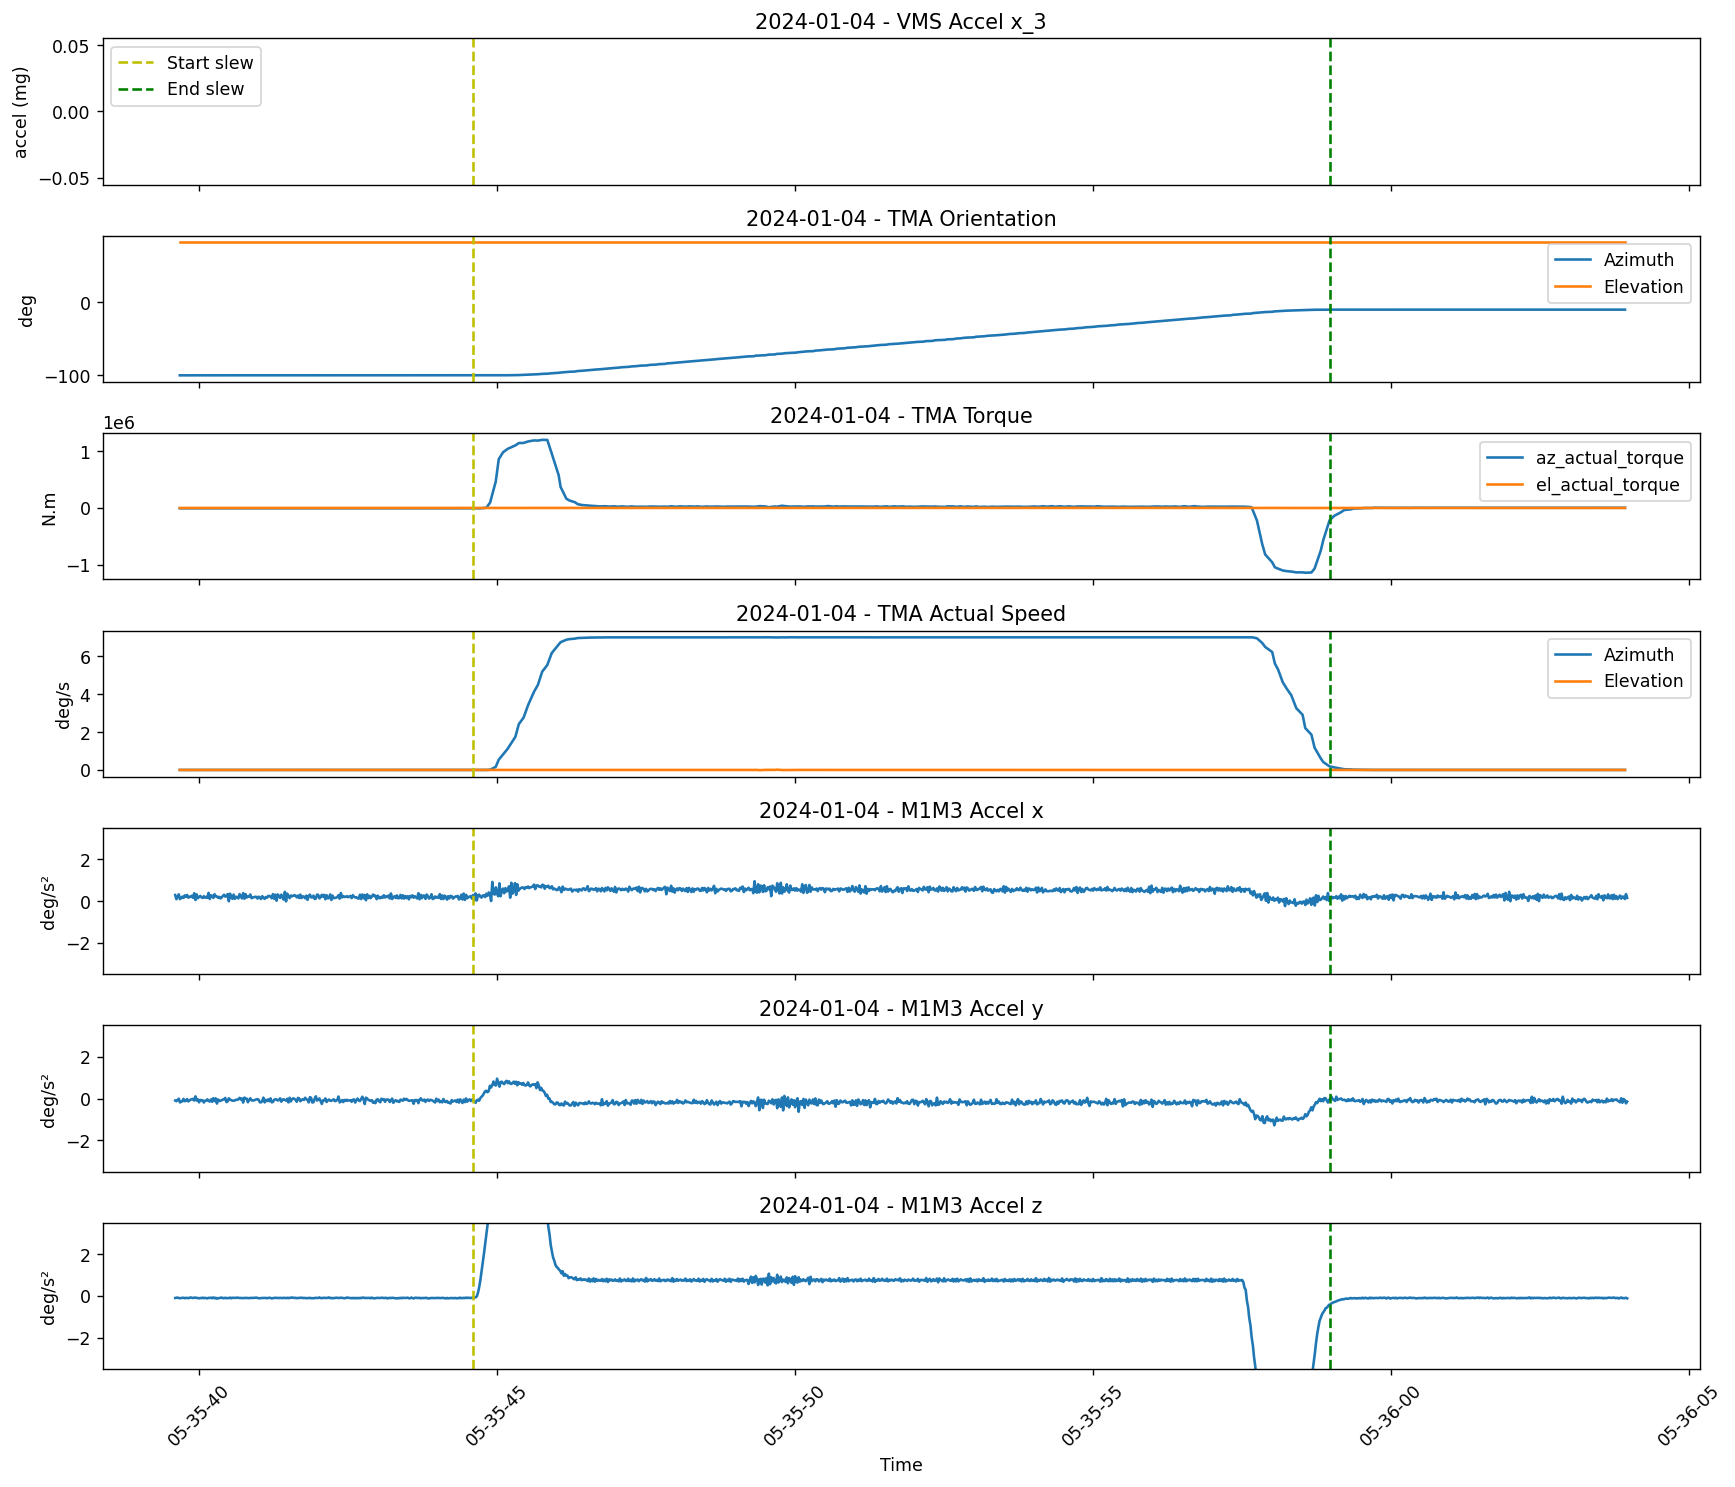

In [96]:
# Plot a few quantities to check that we have selected a good quality slew

fig, ax = plt.subplots(7, 1, sharex=True, dpi=125, figsize=(14, 12))
ax[0].plot(vms_m1m3_data["times"][sel], vms_m1m3_data["m1m3_x_3"][sel])
ax[0].set(ylabel="accel (mg)", title=f"{vms_date} - VMS Accel x_3")
ax[1].plot(df_azi.index, df_azi["actualPosition"], label="Azimuth")
ax[1].plot(df_ele.index, df_ele["actualPosition"], label="Elevation")
ax[1].legend()
ax[1].set(ylabel="deg", title=f"{vms_date} - TMA Orientation")
ax[2].plot(df_azi.index, df_azi["actualTorque"], label="az_actual_torque")
ax[2].plot(df_ele.index, df_ele["actualTorque"], label="el_actual_torque")
ax[2].set(ylabel="N.m", title=f"{vms_date} - TMA Torque")
ax[2].legend()
ax[3].plot(df_azi.index, df_azi["actualVelocity"], label="Azimuth")
ax[3].plot(df_ele.index, df_ele["actualVelocity"], label="Elevation")
ax[3].set(ylabel="deg/s", title=f"{vms_date} - TMA Actual Speed")
ax[3].legend()
ax[4].plot(df_accel.index, df_accel["angularAccelerationX"])
ax[4].set(ylabel="deg/s²", title=f"{vms_date} - M1M3 Accel x")
ax[4].set_ylim([-3.5, 3.5])
ax[5].plot(df_accel.index, df_accel["angularAccelerationY"])
ax[5].set(ylabel="deg/s²", title=f"{vms_date} - M1M3 Accel y")
ax[5].set_ylim([-3.5, 3.5])
ax[6].plot(df_accel.index, df_accel["angularAccelerationZ"])
ax[6].set(ylabel="deg/s²", title=f"{vms_date} - M1M3 Accel z")
ax[6].set_ylim([-3.5, 3.5])
ax[len(ax) - 1].set_xlabel("Time")
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
    plt.setp(ax[i].get_xticklabels(), rotation=45)
    for ct, ev in enumerate(selected):
        if i == 0 and ct == 0:
            ax[i].axvline(ev.begin.datetime64, color="y", ls="--", label="Start slew")
            ax[i].axvline(ev.end.datetime64, color="g", ls="--", label="End slew")
            ax[0].legend()
        else:
            ax[i].axvline(ev.begin.datetime64, color="y", ls="--")
            ax[i].axvline(ev.end.datetime64, color="g", ls="--")
    if i == 0:
        ax[0].legend(loc="upper left")
fig.tight_layout()
fig.savefig(f"{plot_dir}/overview-{vms_date}-{slew_select}.png")

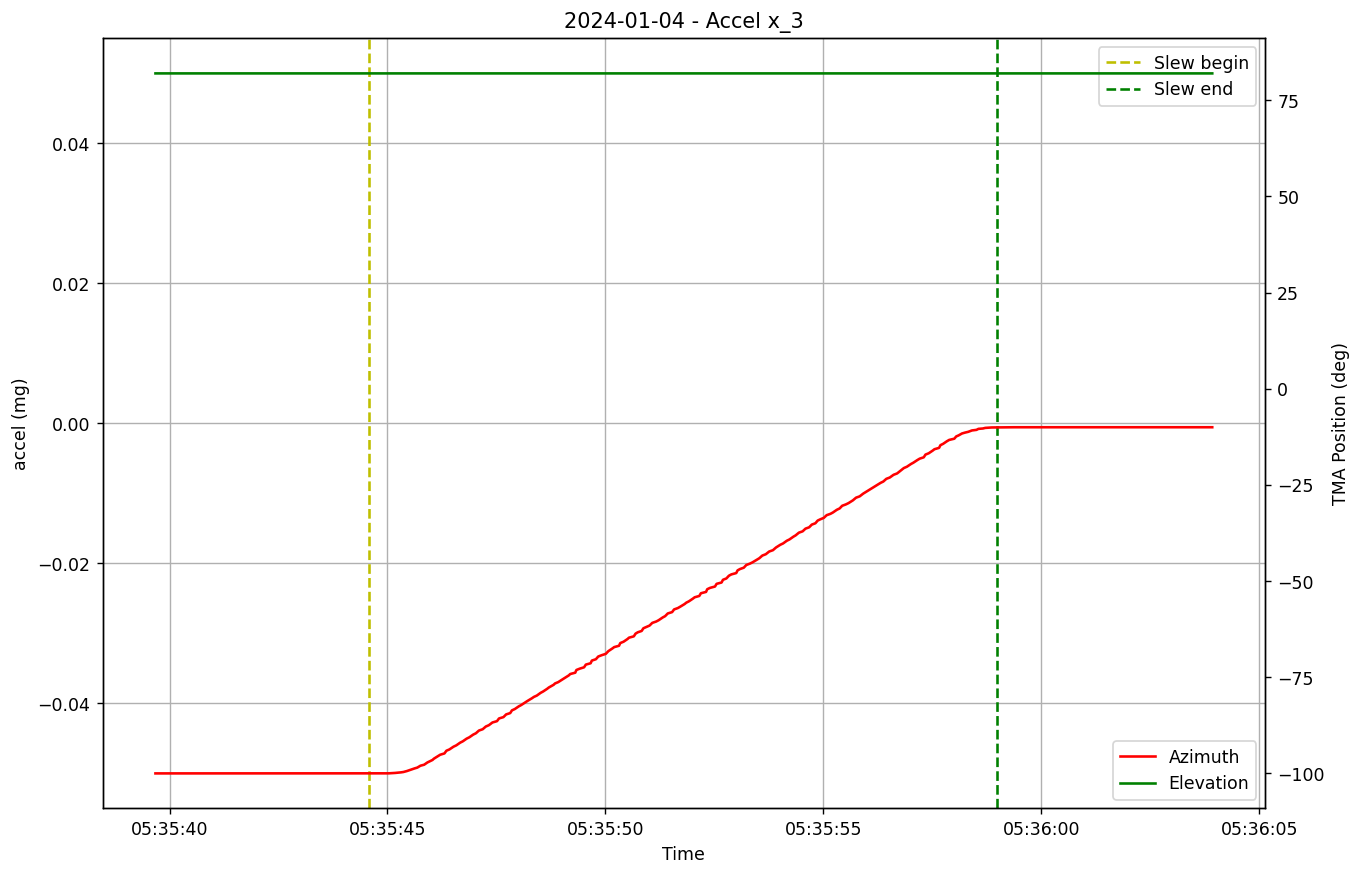

In [111]:
# Zoom in the acceleration measured by the VMS
fig, ax = plt.subplots(1, 1, dpi=125, figsize=(12, 8))
ax.plot(vms_m1m3_data["times"][sel], vms_m1m3_data["m1m3_x_3"][sel])
ax.set(ylabel="accel (mg)", xlabel="Time", title=f"{vms_date} - Accel x_3")
ax2 = ax.twinx()
ax2.plot(df_azi.index, df_azi["actualPosition"], c="red", label="Azimuth")
ax2.plot(df_ele.index, df_ele["actualPosition"], c="green", label="Elevation")
ax2.set_ylabel("TMA Position (deg)")
ax2.legend()
for i, ev in enumerate(selected):
    ax.axvline(ev.begin.datetime64, color="y", ls="--", label="Slew begin")
    ax.axvline(ev.end.datetime64, color="g", ls="--", label="Slew end")
    if i == 0:
        ax.legend()
ax.grid(axis="both")
fig.savefig(f"{plot_dir}/VMS-zoom-{vms_date}-{slew_select}.png")

## Check whether HP forces are correlated with VMS data

In [98]:
df_hp = getEfdData(
    client, "lsst.sal.MTM1M3.hardpointActuatorData", begin=start_slew, end=end_slew
)

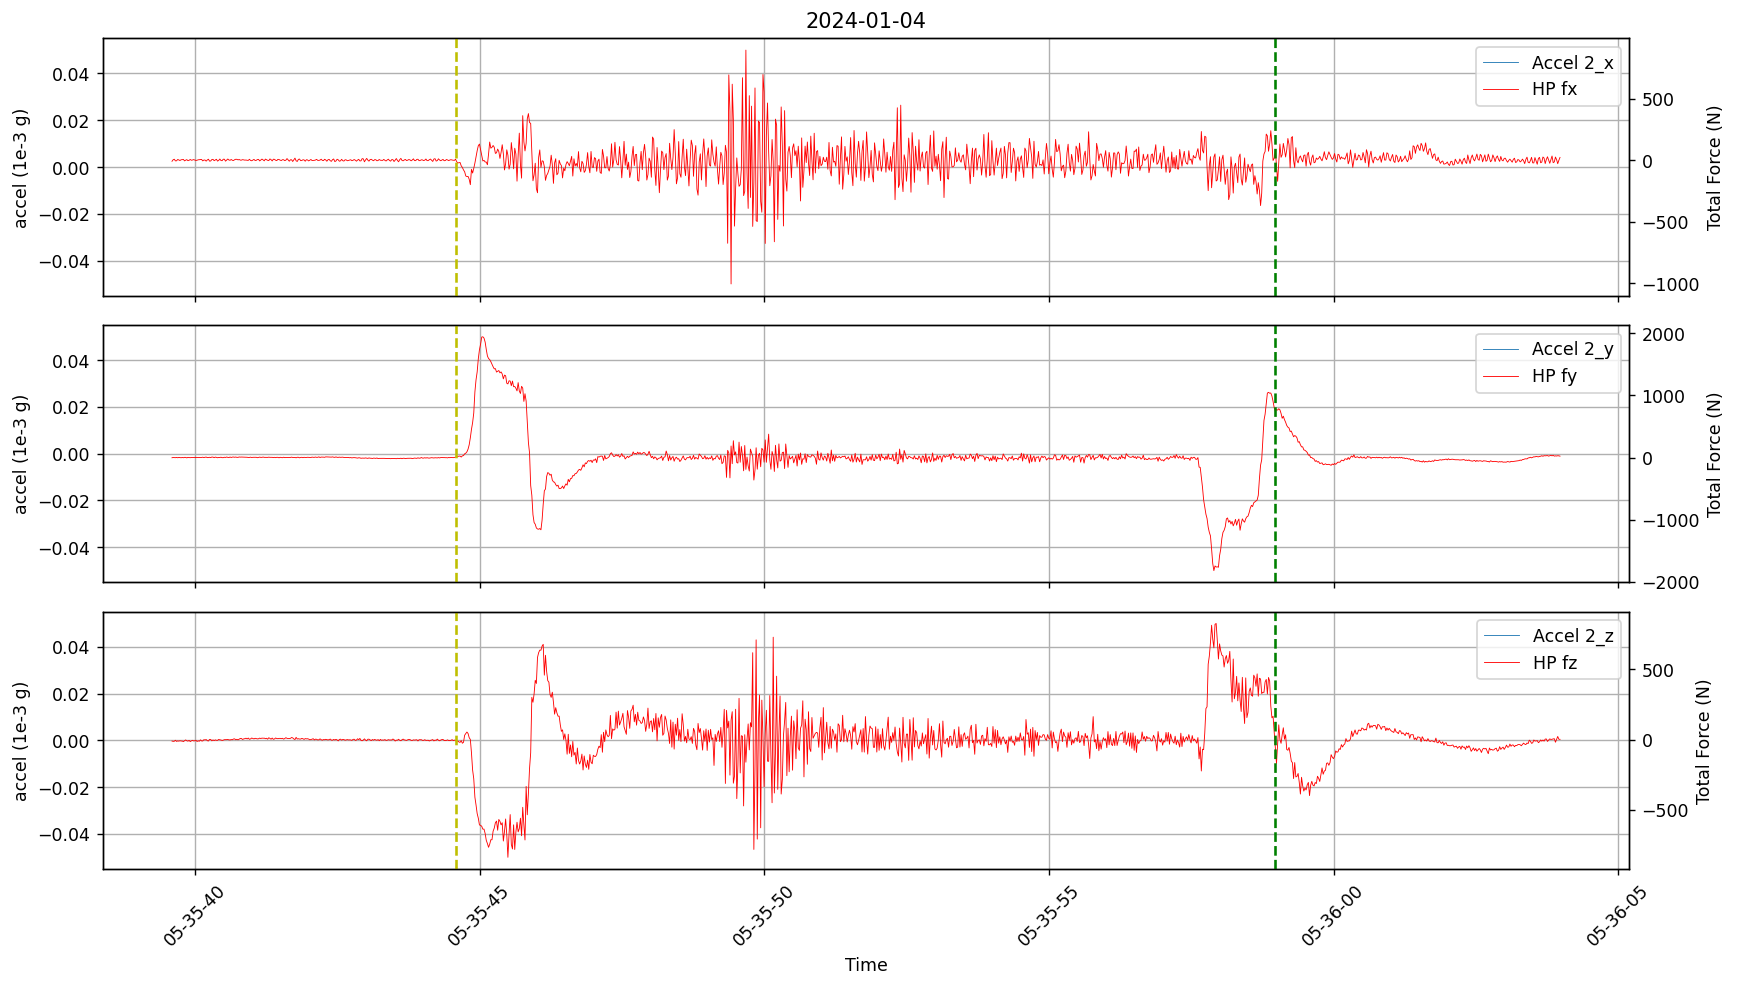

In [99]:
fig, ax = plt.subplots(3, 1, sharex=True, dpi=125, figsize=(14, 8))
bx = []
for i, axis in enumerate("xyz"):
    lns1 = ax[i].plot(
        vms_m1m3_data["times"][sel],
        vms_m1m3_data[f"m1m3_{axis}_2"][sel],
        lw=0.5,
        label=f"Accel 2_{axis}",
    )
    ax[i].set(ylabel="accel (1e-3 g)")
    bx.append(ax[i].twinx())
    lns2 = bx[i].plot(
        df_hp.index, df_hp[f"f{axis}"], c="red", lw=0.5, label=f"HP f{axis}"
    )
    bx[i].set_ylabel(f"Total Force (N)")
    ax[i].grid(axis="both")
    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax[i].legend(lns, labs)
    for ct, ev in enumerate(selected):
        if i == 0 and ct == 0:
            bx[i].axvline(ev.begin.datetime64, color="y", ls="--", label="Start slew")
            bx[i].axvline(ev.end.datetime64, color="g", ls="--", label="End slew")
        else:
            bx[i].axvline(ev.begin.datetime64, color="y", ls="--")
            bx[i].axvline(ev.end.datetime64, color="g", ls="--")
ax[2].set(xlabel="Time")
ax[0].set(title=f"{vms_date}")
ax[2].xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
plt.setp(ax[i].get_xticklabels(), rotation=45)
fig.tight_layout()
fig.savefig(f"{plot_dir}/VMS-HP-{vms_date}-{slew_select}.png")

In [100]:
def compare_mount_hardpoints(
    df_mtmount_ele,
    df_mtmount_azi,
    df_hp,
    begin,
    end,
):
    fig, axs = plt.subplots(1, 1, dpi=125, figsize=(15, 8))
    ax = axs  # [0]
    df_plot = df_hp["measuredForce0"][begin:end]
    ax.plot(df_plot, color="red", lw="0.5", label="HP 0")
    df_plot = df_hp["measuredForce1"][begin:end]
    ax.plot(df_plot, color="blue", lw="0.5", label="HP 1")
    df_plot = df_hp["measuredForce2"][begin:end]
    ax.plot(df_plot, color="black", lw="0.5", label="HP 2")
    df_plot = df_hp["measuredForce3"][begin:end]
    ax.plot(df_plot, color="green", lw="0.5", label="HP 3")
    df_plot = df_hp["measuredForce4"][begin:end]
    ax.plot(df_plot, color="orange", lw="0.5", label="HP 4")
    df_plot = df_hp["measuredForce5"][begin:end]
    ax.plot(df_plot, color="yellow", lw="0.5", label="HP 5")
    ax.set_ylabel("HP Force \n[N]")
    # ax.legend()
    ax2 = ax.twinx()
    # ax = axs[1]
    df_plot = df_mtmount_ele["actualPosition"][begin:end]
    ax2.plot(df_plot, color="green", lw="0.5", label="el")
    # ax.axvline(begin, lw="0.5", c="k", label="Slew start")
    # ax.axvline(end, lw="0.5", c="b", label="Slew stop")

    # ax = axs[2]
    df_plot = df_mtmount_azi["actualPosition"][begin:end]
    ax2.plot(df_plot, color="red", lw="0.5", label="az")
    ax2.set_ylabel("TMA El & Azimuth \nPosition\n[deg]")

    ax2.set_xlabel("UTC")
    ax2.legend()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=1)
    fig.suptitle(t0)
    fig.tight_layout()

In [101]:
postPadding = 50.0

start_slew = Time(ev.begin, format="isot", scale="utc")  # start of slew
t0 = pd.to_datetime(start_slew.value, utc=True)  # astropy Time to Timestamp conversion
end_slew = Time(ev.end, format="isot", scale="utc")  # end of slew
t1 = pd.to_datetime(end_slew.value, utc=True)  # astropy Time to Timestamp conversion

# Get mount data
df_mtmount_ele = getEfdData(
    client,
    "lsst.sal.MTMount.elevation",
    begin=start_slew,
    end=end_slew,
)
df_mtmount_azi = getEfdData(
    client,
    "lsst.sal.MTMount.azimuth",
    begin=start_slew,
    end=end_slew,
)
df_hp = getEfdData(
    client, "lsst.sal.MTM1M3.hardpointActuatorData", begin=start_slew, end=end_slew
)

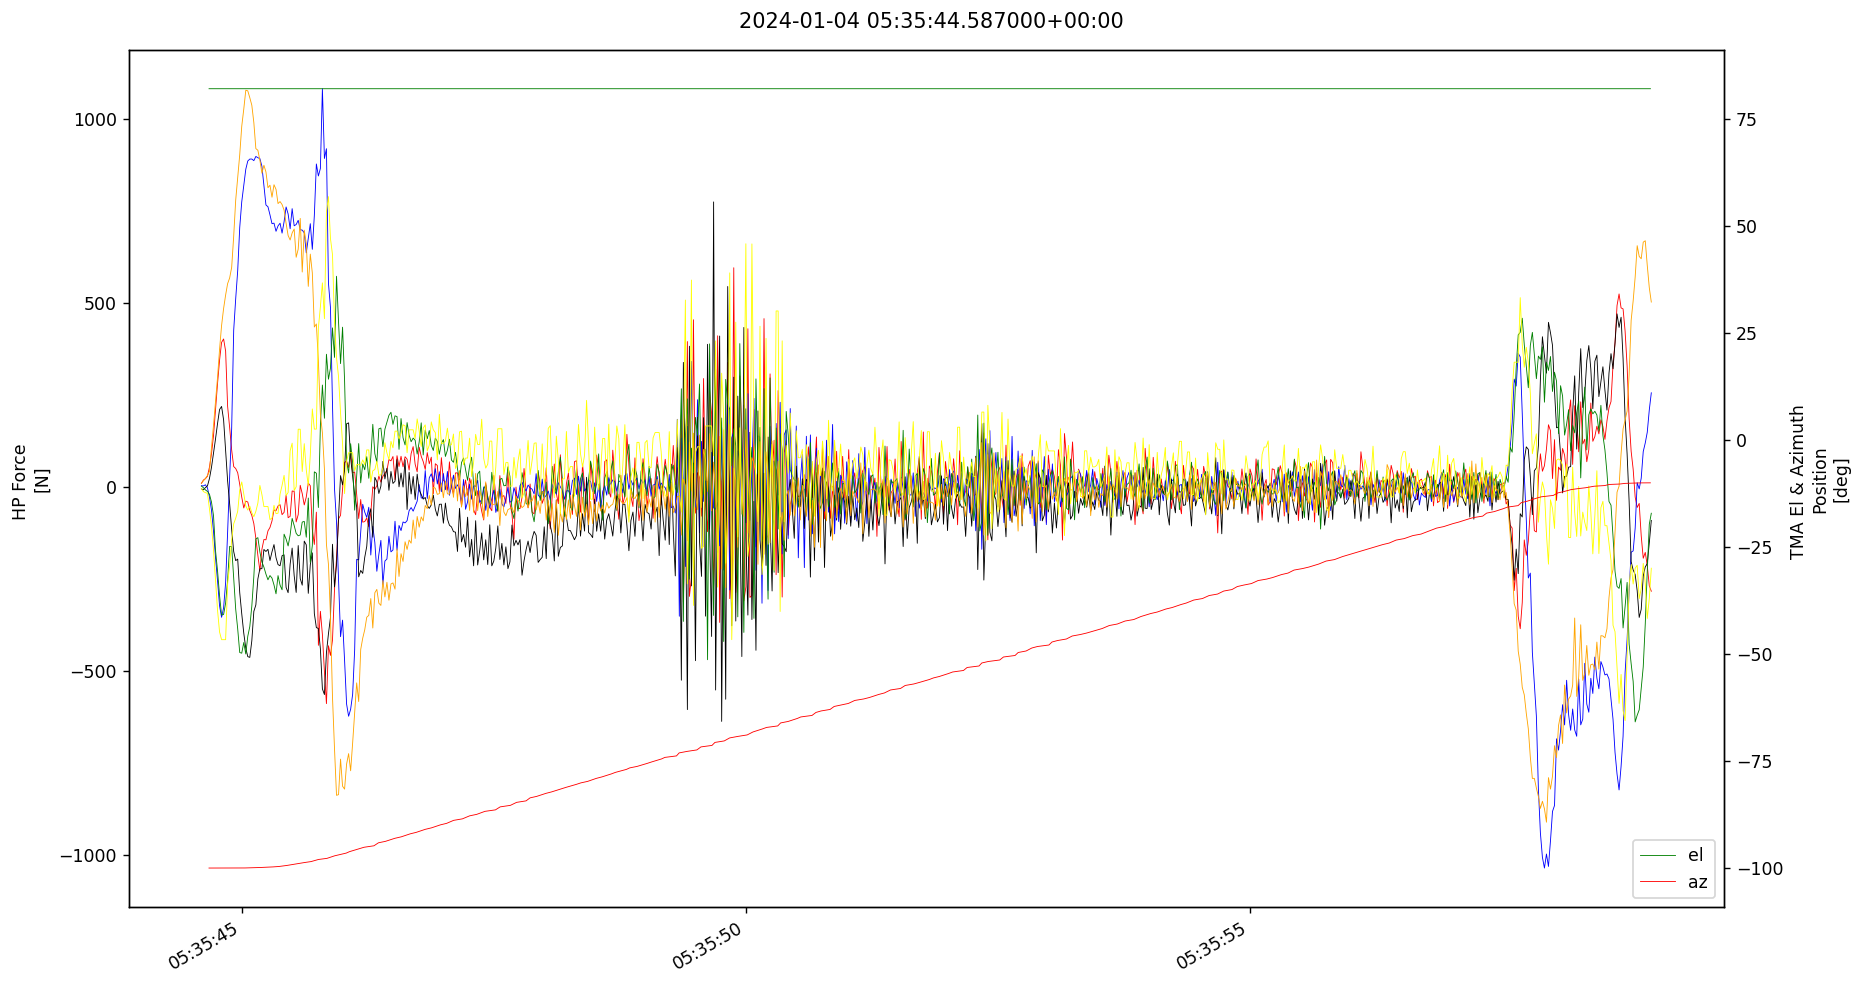

In [102]:
%matplotlib inline
compare_mount_hardpoints(
    df_mtmount_ele,
    df_mtmount_azi,
    df_hp,
    t0,
    t1,
)

In [112]:
def compare_mount_hardpoints_seperate_plots(
    df_mtmount_ele,
    df_mtmount_azi,
    df_hp,
    begin,
    end,
):
    fig, axs = plt.subplots(3, 1, dpi=125, figsize=(15, 8))
    ax = axs[0]
    df_plot = df_hp["measuredForce0"][begin:end]
    ax.plot(df_plot, color="red", lw="0.5", label="HP 0")
    df_plot = df_hp["measuredForce1"][begin:end]
    ax.plot(df_plot, color="blue", lw="0.5", label="HP 1")
    df_plot = df_hp["measuredForce2"][begin:end]
    ax.plot(df_plot, color="black", lw="0.5", label="HP 2")
    df_plot = df_hp["measuredForce3"][begin:end]
    ax.plot(df_plot, color="green", lw="0.5", label="HP 3")
    df_plot = df_hp["measuredForce4"][begin:end]
    ax.plot(df_plot, color="orange", lw="0.5", label="HP 4")
    df_plot = df_hp["measuredForce5"][begin:end]
    ax.plot(df_plot, color="yellow", lw="0.5", label="HP 5")
    ax.set_ylabel("HP Force \n[N]")

    ax = axs[1]
    df_plot = df_mtmount_ele["actualPosition"][begin:end]
    ax.plot(df_plot, color="green", lw="0.5")
    ax.set_ylabel("TMA Elevation \nPosition\n[deg]")
    # ax.axvline(begin, lw="0.5", c="k", label="Slew start")
    # ax.axvline(end, lw="0.5", c="b", label="Slew stop")

    ax = axs[2]
    df_plot = df_mtmount_azi["actualPosition"][begin:end]
    ax.plot(df_plot, color="red", lw="0.5")
    ax.set_ylabel("TMA Azimuth \nPosition\n[deg]")

    ax.set_xlabel("UTC")
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=1)
    fig.suptitle(t0)
    fig.legend()
    fig.tight_layout()

In [ ]:
%matplotlib inline
compare_mount_hardpoints_seperate_plots(
    df_mtmount_ele,
    df_mtmount_azi,
    df_hp,
    t0,
    t1,
)